In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics SVR Report's Experiments</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

## Support Vector Regression

In [6]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['optimizer'] = cv_results['param_optimizer']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'epsilon', 'fit_time', 
                         'train_r2', 'test_r2', 
                         'nr_train_sv', 'nr_test_sv']] = cv_results[['param_C', 'mean_fit_time', 
                                                                     'mean_train_r2', 'mean_test_r2',
                                                                     'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
    
    filtered_cv_results['nr_train_sv'] = filtered_cv_results['nr_train_sv'].round().astype(int)
    filtered_cv_results['nr_test_sv'] = filtered_cv_results['nr_test_sv'].round().astype(int)

    return filtered_cv_results

### Epsilon-insensitive loss

#### Primal formulation

In [7]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [8]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


ValueError: x and y must be the same size

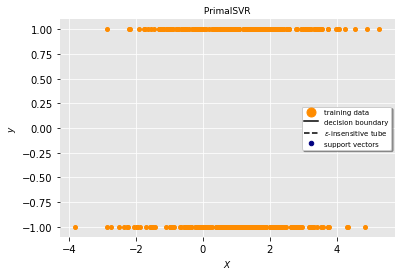

In [12]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=AdaGrad, 
                              learning_rate=1., max_iter=3000),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/svr_hyperplane.png')
plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svr_eps_loss.png')

In [205]:
custom_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_eps_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
custom,1,0.715587,0.972487,0.969923,11,7
custom,10,0.685368,0.974975,0.969923,8,4
custom,100,0.576646,0.977481,0.969923,7,3


In [151]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive'),
                    param_grid={'eps': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [206]:
sklearn_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svr_eps_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
liblinear,1,0.715587,0.972487,0.969923,11,7
liblinear,10,0.685368,0.974975,0.969923,8,4
liblinear,100,0.576646,0.977481,0.969923,7,3


In [207]:
overall_primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(sklearn_primal_svr_eps_cv_results, ignore_index=True)
overall_primal_svr_eps_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', index=False)
overall_primal_svr_eps_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
custom,1,0.715587,0.972487,0.969923,11,7
liblinear,1,0.715587,0.972487,0.969923,11,7
custom,10,0.685368,0.974975,0.969923,8,4
liblinear,10,0.685368,0.974975,0.969923,8,4
custom,100,0.576646,0.977481,0.969923,7,3
liblinear,100,0.576646,0.977481,0.969923,7,3


#### Dual formulations

In [154]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_non_linearly_separable_data

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import GridSearchCV

In [155]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(svr.support_)}

##### Linear SVR

In [208]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [209]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
smo,1,0.071781,0.990012,0.990050,12,12
cvxopt,1,0.046403,0.990012,0.990050,12,12
smo,10,0.085767,0.992519,0.980100,7,7
cvxopt,10,0.025000,0.992519,0.980100,7,7
smo,100,0.121755,0.992519,0.980100,6,6
cvxopt,100,0.020040,0.992519,0.980100,6,6


In [210]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVR(),
                    param_grid={'eps': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [211]:
sklinear_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_linear_dual_svr_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
libsvm,1,0.004200,0.990012,0.990050,26,26
libsvm,10,0.004469,0.997512,0.990050,13,13
libsvm,100,0.003470,0.997512,0.985075,10,10


In [212]:
overall_linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(sklinear_linear_dual_svr_cv_results, ignore_index=True)
overall_linear_dual_svr_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', index=False)
overall_linear_dual_svr_cv_results.style.hide_index()

optimizer,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
cvxopt,1,0.046403,0.990012,0.990050,12,12
libsvm,1,0.004200,0.990012,0.990050,26,26
smo,1,0.071781,0.990012,0.990050,12,12
cvxopt,10,0.025000,0.992519,0.980100,7,7
libsvm,10,0.004469,0.997512,0.990050,13,13
smo,10,0.085767,0.992519,0.980100,7,7
cvxopt,100,0.020040,0.992519,0.980100,6,6
libsvm,100,0.003470,0.997512,0.985075,10,10
smo,100,0.121755,0.992519,0.980100,6,6


In [213]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [214]:
linear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
qp,1,0.021777,0.977537,0.975124,130,130
qp,10,0.022203,0.977537,0.975124,130,130
qp,100,0.026498,0.977537,0.975124,130,130


In [215]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [216]:
linear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,1,0.022301,0.995006,0.995025,132,132
bcqp,10,0.023501,0.995006,0.995025,132,132
bcqp,100,0.019523,0.995006,0.995025,132,132


In [217]:
linear_lagrangian_dual_svr_cv_results = linear_qp_lagrangian_dual_svr_cv_results.append(linear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
linear_lagrangian_dual_svr_cv_results.sort_values(['C', 'ld'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', index=False)
linear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,1,0.022301,0.995006,0.995025,132,132
qp,1,0.021777,0.977537,0.975124,130,130
bcqp,10,0.023501,0.995006,0.995025,132,132
qp,10,0.022203,0.977537,0.975124,130,130
bcqp,100,0.019523,0.995006,0.995025,132,132
qp,100,0.026498,0.977537,0.975124,130,130


##### Nonlinear SVR

In [218]:
X, y = generate_non_linearly_separable_data()

grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [219]:
custom_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_nonlinear_dual_svr_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
smo,poly,1,0.446164,1.000000,0.997494,8,8
cvxopt,poly,1,0.253555,1.000000,0.994987,8,8
smo,rbf,1,0.787757,1.000000,1.000000,40,40
cvxopt,rbf,1,0.065434,1.000000,1.000000,42,42
smo,poly,10,0.274295,1.000000,0.997494,8,8
cvxopt,poly,10,0.100806,1.000000,0.994987,8,8
smo,rbf,10,0.636188,1.000000,1.000000,38,38
cvxopt,rbf,10,0.065290,1.000000,1.000000,42,42
smo,poly,100,0.304340,1.000000,0.997494,8,8
cvxopt,poly,100,0.108034,1.000000,0.994987,8,8


In [236]:
X, y = generate_non_linearly_separable_data()

grid = GridSearchCV(SklSVR(),
                    param_grid=[{'eps': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['auto']},
                                {'eps': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['auto']}],
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [221]:
sklinear_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_nonlinear_dual_svr_cv_results.insert(0, 'optimizer', 'libsvm')
sklinear_nonlinear_dual_svr_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
libsvm,rbf,10,0.005806,1.000000,1.000000,36,36
libsvm,poly,100,0.004066,1.000000,0.994987,7,7
libsvm,rbf,100,0.005325,1.000000,1.000000,36,36


In [225]:
overall_nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(sklinear_nonlinear_dual_svr_cv_results, ignore_index=True)
overall_nonlinear_dual_svr_cv_results.sort_values(['C', 'kernel', 'optimizer'], inplace=True)
overall_nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', index=False)
overall_nonlinear_dual_svr_cv_results.style.hide_index()

optimizer,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
cvxopt,poly,1,0.253555,1.000000,0.994987,8,8
libsvm,poly,1,0.003886,1.000000,0.994987,7,7
smo,poly,1,0.446164,1.000000,0.997494,8,8
cvxopt,rbf,1,0.065434,1.000000,1.000000,42,42
libsvm,rbf,1,0.006386,1.000000,1.000000,38,38
smo,rbf,1,0.787757,1.000000,1.000000,40,40
cvxopt,poly,10,0.100806,1.000000,0.994987,8,8
libsvm,poly,10,0.003939,1.000000,0.994987,7,7
smo,poly,10,0.274295,1.000000,0.997494,8,8
cvxopt,rbf,10,0.065290,1.000000,1.000000,42,42


In [229]:
X, y = generate_non_linearly_separable_data()

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [230]:
nonlinear_qp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
qp,poly,100,0.048170,0.823787,0.738095,163,163
qp,rbf,100,0.941620,1.000000,0.997494,142,142


In [231]:
X, y = generate_non_linearly_separable_data()

grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='auto'), 
                                           GaussianKernel(gamma='auto')]},
                    scoring=dual_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [232]:
nonlinear_bcqp_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svr_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


In [234]:
nonlinear_lagrangian_dual_svr_cv_results = nonlinear_qp_lagrangian_dual_svr_cv_results.append(nonlinear_bcqp_lagrangian_dual_svr_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['C', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', index=False)
nonlinear_lagrangian_dual_svr_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
bcqp,poly,1,3.186200,0.853759,0.728145,212,212
bcqp,rbf,1,0.044137,1.000000,1.000000,205,205
qp,poly,1,0.117401,0.823787,0.738095,163,163
qp,rbf,1,1.696029,1.000000,0.997494,143,143
bcqp,poly,10,2.776435,0.853759,0.728145,212,212
bcqp,rbf,10,0.035251,1.000000,1.000000,205,205
qp,poly,10,0.134212,0.823787,0.738095,163,163
qp,rbf,10,1.086226,0.998752,0.997494,142,142
bcqp,poly,100,2.888524,0.853759,0.728145,212,212
bcqp,rbf,100,0.035742,1.000000,1.000000,205,205


### Squared Epsilon-insensitive loss

#### Primal formulation

Fitting 3 folds for each of 3 candidates, totalling 9 fits


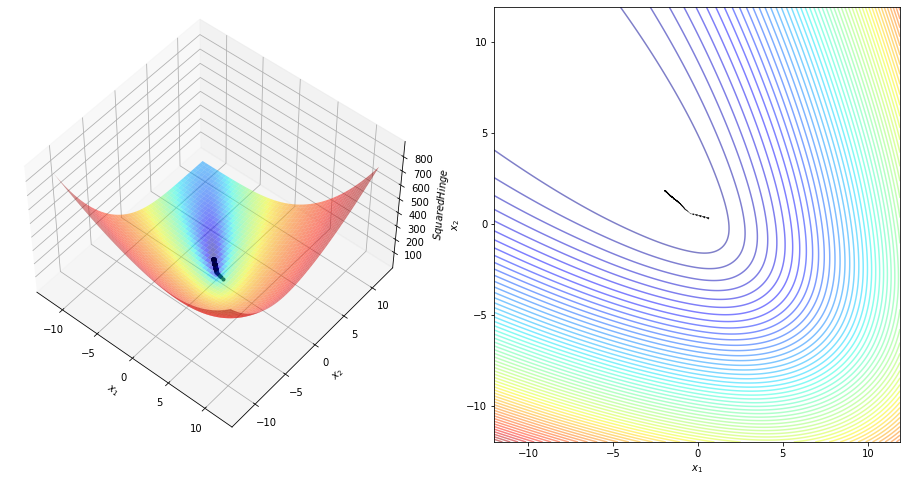

In [94]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.1),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svr_squared_eps_loss.png')

In [95]:
custom_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svr_squared_eps_cv_results.insert(0, 'optimizer', 'custom')
custom_primal_svr_squared_eps_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,custom,0.914336,0.977500,0.980024,12,6
10,custom,0.887345,0.982512,0.980024,7,4
100,custom,0.719462,0.967512,0.970074,4,3


In [96]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive'),
                    param_grid={'eps': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt best r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [97]:
sklearn_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svr_squared_eps_cv_results.insert(0, 'optimizer', 'liblinear')
sklearn_primal_svr_squared_eps_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,liblinear,0.001110,0.977500,0.965023,18,9
10,liblinear,0.001477,0.977500,0.964948,12,7
100,liblinear,0.001678,0.980006,0.964948,13,7


In [98]:
overall_primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(sklearn_primal_svr_squared_eps_cv_results, ignore_index=True)
overall_primal_svr_squared_eps_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', index=False)
overall_primal_svr_squared_eps_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,custom,0.914336,0.977500,0.980024,12,6
1,liblinear,0.001110,0.977500,0.965023,18,9
10,custom,0.887345,0.982512,0.980024,7,4
10,liblinear,0.001477,0.977500,0.964948,12,7
100,custom,0.719462,0.967512,0.970074,4,3
100,liblinear,0.001678,0.980006,0.964948,13,7


## Support Vector Regression

### Epsilon-insensitive loss

#### Primal formulation

In [4]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.datasets import make_regression

In [ ]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

#### Dual formulations

In [ ]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(svr.support_)}

### Squared Epsilon-insensitive loss

#### Primal formulation

epoch	iter	 cost	
   0	   0	 5.0554e+02	val_loss:  4.0542e+02	r2:  0.0186	val_r2:  0.0202
 200	 200	 3.0884e+02	val_loss:  2.6962e+02	r2:  0.6507	val_r2:  0.6410
 400	 400	 2.4122e+02	val_loss:  2.3162e+02	r2:  0.7963	val_r2:  0.7856
 600	 600	 1.9700e+02	val_loss:  2.0925e+02	r2:  0.8696	val_r2:  0.8589
 800	 800	 1.6619e+02	val_loss:  1.9435e+02	r2:  0.9114	val_r2:  0.9009
1000	1000	 1.4632e+02	val_loss:  1.8556e+02	r2:  0.9364	val_r2:  0.9263
1200	1200	 1.3295e+02	val_loss:  1.8464e+02	r2:  0.9519	val_r2:  0.9422
1400	1400	 1.2292e+02	val_loss:  1.8450e+02	r2:  0.9616	val_r2:  0.9523
1600	1600	 1.1609e+02	val_loss:  1.8471e+02	r2:  0.9678	val_r2:  0.9587
1800	1800	 1.1205e+02	val_loss:  1.8510e+02	r2:  0.9717	val_r2:  0.9629
2000	2000	 1.1023e+02	val_loss:  1.8549e+02	r2:  0.9743	val_r2:  0.9657
2200	2200	 1.0881e+02	val_loss:  1.8585e+02	r2:  0.9759	val_r2:  0.9675
2400	2400	 1.0822e+02	val_loss:  1.8617e+02	r2:  0.9769	val_r2:  0.9687
2600	2600	 1.0784e+02	val_loss:  1.8644e+02	r2

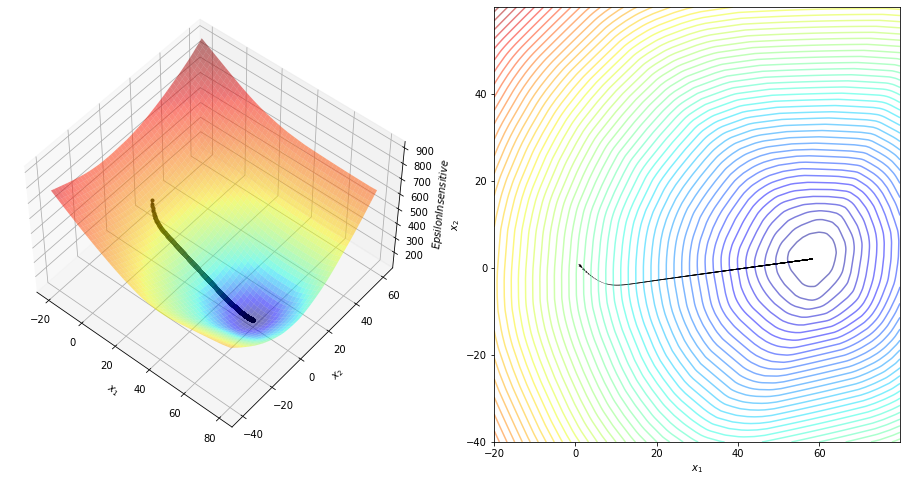

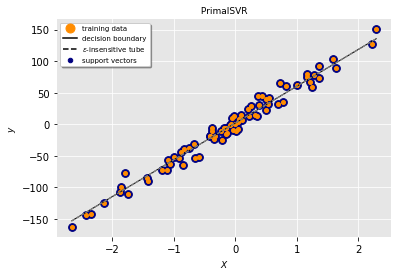

svr r2 score is 0.977062497664484
svr found 75 support vectors from 75 examples
svr w is [58.22121652]
svr b is 2.03514638565529

CPU times: user 1.94 ms, sys: 124 µs, total: 2.07 ms
Wall time: 1.62 ms


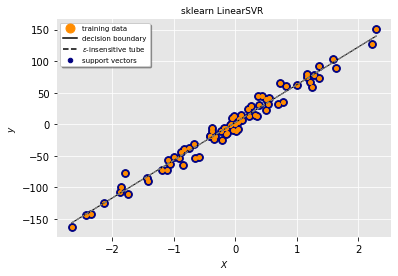

sklearn svr r2 score is 0.9764953146596664
sklearn svr found 74 support vectors from 75 examples
sklearn svr w is [59.71438415]
sklearn svr b is [2.91299935]


In [5]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, C=10, optimizer=AdaGrad, 
                learning_rate=1., max_iter=3000, validation_split=0.2, verbose=200)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SkLinearSVR(loss='epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

iter	feval	 cost		 gnorm
   0	   1	 3.5616e+04	 1.2014e+03	ls:  1	it:  1	astar:  4.7324e-02
   1	   3	 1.5359e+03	 1.5819e+02	ls:  1	it:  1	astar:  5.1479e-02
   2	   5	 8.9685e+02	 2.2657e+01	ls:  1	it:  1	astar:  4.7324e-02
   3	   7	 8.8499e+02	 2.9833e+00	ls:  1	it:  1	astar:  5.1479e-02
   4	   9	 8.8477e+02	 4.2729e-01	ls:  1	it:  2	astar:  4.7324e-02
   5	  11	 8.8477e+02	 5.6261e-02	ls:  1	it:  8	astar:  5.1479e-02
   6	  19	 8.8477e+02	 8.0582e-03	ls:  1	it:  7	astar:  4.7324e-02
   7	  26	 8.8477e+02	 1.0610e-03	ls:  1	it:  6	astar:  5.1479e-02
   8	  32	 8.8477e+02	 1.5197e-04	ls:  1	it:  2	astar:  4.7324e-02
   9	  34	 8.8477e+02	 2.0009e-05	ls:  1	it:  4	astar:  5.1574e-02
  10	  38	 8.8477e+02	 2.8714e-06	ls:  1	it:  2	astar:  4.7165e-02
  11	  40	 8.8477e+02	 3.7372e-07

CPU times: user 12.1 ms, sys: 4.33 ms, total: 16.4 ms
Wall time: 12.8 ms


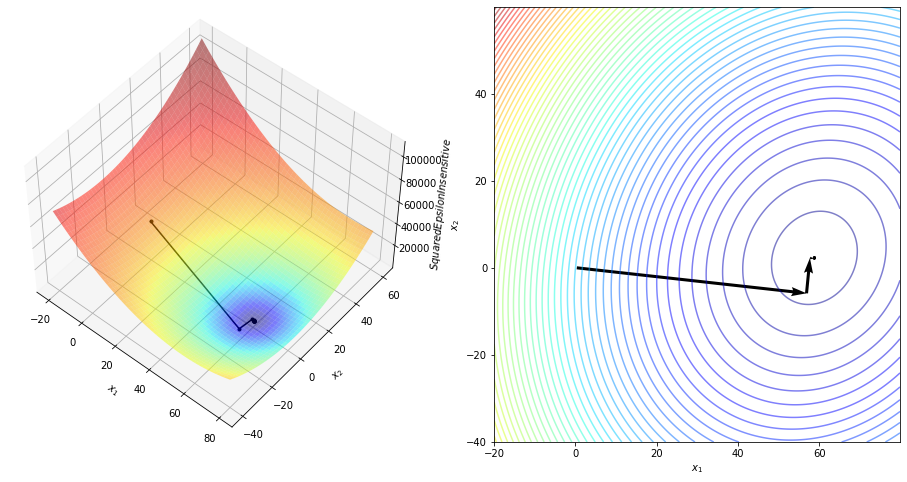

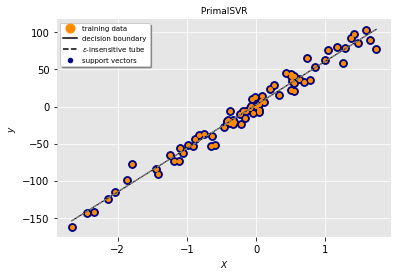

svr r2 score is 0.9815988018645927
svr found 75 support vectors from 75 examples
svr w is [58.83256051]
svr b is 2.303905473543353

CPU times: user 3.37 ms, sys: 0 ns, total: 3.37 ms
Wall time: 2.77 ms


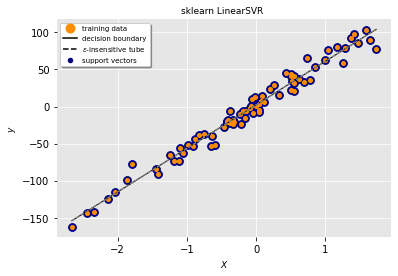

sklearn svr r2 score is 0.981583884871758
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [58.81896316]
sklearn svr b is [2.30068004]


In [31]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = PrimalSVR(loss=squared_epsilon_insensitive, epsilon=0.1, C=10, 
                optimizer=SteepestGradientDescent, verbose=True)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SkLinearSVR(loss='squared_epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [32]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost
   0	-6.2037e+03
   3	-6.8519e+03
   6	-6.9873e+03
   9	-7.0608e+03
  12	-7.0624e+03
  15	-7.0641e+03
  18	-7.0657e+03
  21	-7.0673e+03
  24	-7.0682e+03
  27	-7.0691e+03
  30	-7.0700e+03
  33	-7.0709e+03
  36	-7.0716e+03
  39	-7.0722e+03

CPU times: user 822 ms, sys: 354 ms, total: 1.18 s
Wall time: 191 ms


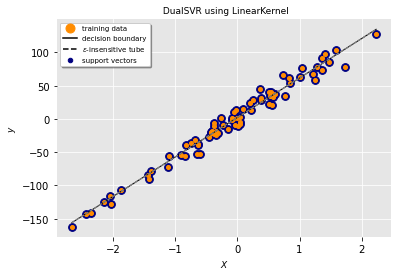

svr r2 score is 0.974828140190886
svr found 75 support vectors from 75 examples
svr w is [59.47669884]
svr b is 2.122650013728763

     pcost       dcost       gap    pres   dres
 0: -7.9071e+03 -2.2785e+04  5e+04  1e+00  5e-16
 1: -5.3712e+03 -1.2744e+04  7e+03  6e-14  4e-16
 2: -6.5430e+03 -7.4715e+03  9e+02  1e-13  3e-16
 3: -6.9645e+03 -7.1609e+03  2e+02  1e-13  3e-16
 4: -7.0471e+03 -7.0939e+03  5e+01  8e-14  3e-16
 5: -7.0698e+03 -7.0747e+03  5e+00  5e-14  3e-16
 6: -7.0722e+03 -7.0723e+03  1e-01  9e-14  3e-16
 7: -7.0723e+03 -7.0723e+03  1e-03  5e-14  3e-16
Optimal solution found.

CPU times: user 229 ms, sys: 93.9 ms, total: 323 ms
Wall time: 50.1 ms


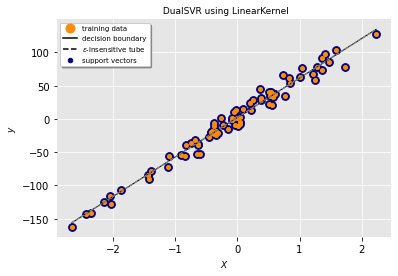

cvxopt svr r2 score is 0.9748172307112926
cvxopt svr found 75 support vectors from 75 examples
cvxopt svr w is [59.47670217]
cvxopt svr b is 2.0905802493036263

CPU times: user 1.59 ms, sys: 134 µs, total: 1.72 ms
Wall time: 1.07 ms


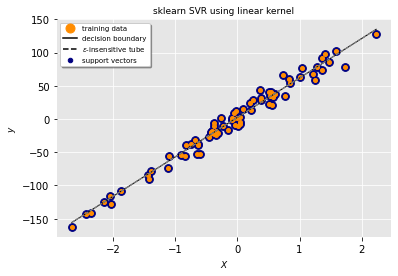

sklearn svr r2 score is 0.974902108680764
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [[59.4766987]]
sklearn svr b is [2.40525739]


In [36]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=SMORegression, verbose=3)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr w is {svr.coef_}')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='linear', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [7]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.7603e+03	pcost: -1.3182e+03	gap:  3.3540e-01	rnorm: 8.8855e-11
 100	 100	-1.7226e+03	pcost: -1.3182e+03	gap:  3.0679e-01	rnorm: 4.7584e-11
 200	 200	-1.7060e+03	pcost: -1.3182e+03	gap:  2.9419e-01	rnorm: 3.7688e-11
 300	 300	-1.6933e+03	pcost: -1.3182e+03	gap:  2.8457e-01	rnorm: 3.7996e-11
 400	 400	-1.6827e+03	pcost: -1.3182e+03	gap:  2.7650e-01	rnorm: 6.2396e-11
 500	 500	-1.6733e+03	pcost: -1.3182e+03	gap:  2.6941e-01	rnorm: 4.4999e-11
 600	 600	-1.6649e+03	pcost: -1.3182e+03	gap:  2.6303e-01	rnorm: 4.6768e-11
 700	 700	-1.6572e+03	pcost: -1.3182e+03	gap:  2.5717e-01	rnorm: 3.9275e-11
 800	 800	-1.6500e+03	pcost: -1.3182e+03	gap:  2.5174e-01	rnorm: 4.9341e-11
 900	 900	-1.6433e+03	pcost: -1.3182e+03	gap:  2.4665e-01	rnorm: 4.4386e-11

CPU times: user 4.01 s, sys: 4.43 s, total: 8.44 s
Wall time: 2.48 s


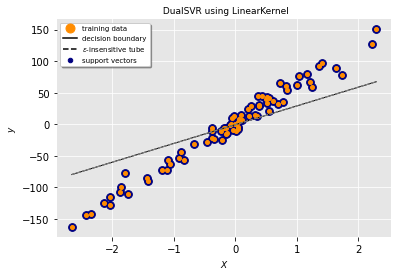

svr r2 score is 0.733784331965381
svr found 75 support vectors from 75 examples
svr w is [29.66739397]
svr b is -0.5829721199584127


In [10]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, fit_intercept=True, verbose=100)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-1.7959e+03	pcost: -1.3445e+03	gap:  3.3579e-01	rnorm: 2.6295e-11
 100	 100	-1.7502e+03	pcost: -1.3445e+03	gap:  3.0180e-01	rnorm: 2.5326e-11
 200	 200	-1.7301e+03	pcost: -1.3445e+03	gap:  2.8687e-01	rnorm: 2.3170e-11
 300	 300	-1.7148e+03	pcost: -1.3445e+03	gap:  2.7548e-01	rnorm: 2.1730e-11
 400	 400	-1.7020e+03	pcost: -1.3445e+03	gap:  2.6594e-01	rnorm: 2.7497e-11
 500	 500	-1.6907e+03	pcost: -1.3445e+03	gap:  2.5756e-01	rnorm: 1.9001e-11
 600	 600	-1.6806e+03	pcost: -1.3445e+03	gap:  2.5002e-01	rnorm: 3.3364e-11
 700	 700	-1.6713e+03	pcost: -1.3445e+03	gap:  2.4312e-01	rnorm: 3.0961e-11
 800	 800	-1.6627e+03	pcost: -1.3445e+03	gap:  2.3671e-01	rnorm: 1.8451e-11
 900	 900	-1.6546e+03	pcost: -1.3445e+03	gap:  2.3072e-01	rnorm: 2.9731e-11

CPU times: user 7.1 s, sys: 9.47 s, total: 16.6 s
Wall time: 5.11 s


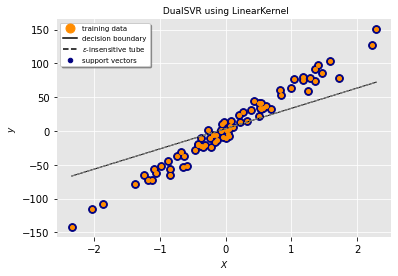

svr r2 score is 0.678831212681787
svr found 75 support vectors from 75 examples
svr w is [29.95083546]
svr b is 3.5753115444611407


In [11]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, fit_intercept=False, verbose=100)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

In [46]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

CPU times: user 28min 51s, sys: 179 ms, total: 28min 51s
Wall time: 28min 51s


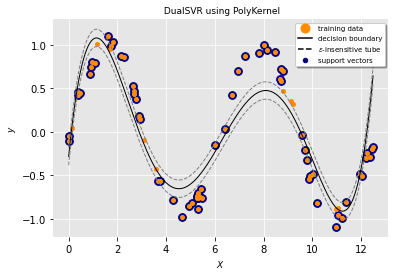

svr r2 score is 0.8866781000272429
svr found 65 support vectors from 75 examples
svr b is -0.2984941354199902

     pcost       dcost       gap    pres   dres
 0: -2.6829e+00 -1.9707e+02  2e+02  3e-17  4e-10
 1: -5.4548e+00 -2.5355e+01  2e+01  1e-16  4e-10
 2: -1.1473e+01 -1.6126e+01  5e+00  2e-16  4e-10
 3: -1.2899e+01 -1.4323e+01  1e+00  2e-16  4e-10
 4: -1.3431e+01 -1.3735e+01  3e-01  2e-16  3e-10
 5: -1.3518e+01 -1.3623e+01  1e-01  2e-16  3e-10
 6: -1.3560e+01 -1.3574e+01  1e-02  2e-16  4e-10
 7: -1.3566e+01 -1.3567e+01  7e-04  1e-16  4e-10
 8: -1.3567e+01 -1.3567e+01  7e-06  2e-16  4e-10
Optimal solution found.

CPU times: user 68.9 ms, sys: 52 ms, total: 121 ms
Wall time: 19.2 ms


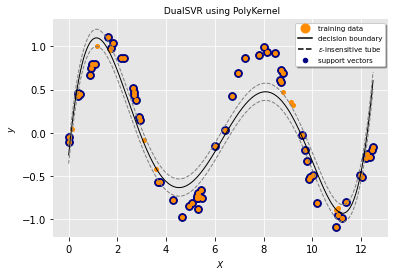

cvxopt svr r2 score is 0.8831486000403188
cvxopt svr found 65 support vectors from 75 examples
cvxopt svr b is 0.025836426934174643

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


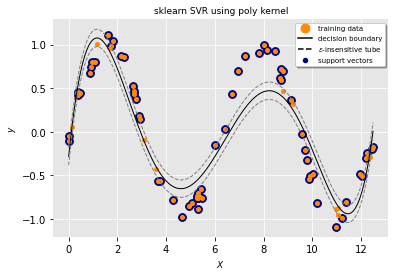

sklearn svr r2 score is 0.8817037899796948
sklearn svr found 64 support vectors from 75 examples
sklearn svr b is [-0.29943022]


In [7]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer=SMORegression, verbose=False)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='poly', degree=5, coef0=4, gamma='scale', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [16]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-4.2129e+00	pcost: -2.4079e+00	gap:  7.4963e-01	itn:  11	rnorm: 2.7479e+00
   1	   1	-3.5003e+00	pcost: -2.4079e+00	gap:  4.5367e-01	itn:  11	rnorm: 2.4907e+00
   2	   2	-3.0560e+00	pcost: -2.4079e+00	gap:  2.6919e-01	itn:  11	rnorm: 2.4030e+00
   3	   3	-2.7258e+00	pcost: -2.4079e+00	gap:  1.3202e-01	itn:  11	rnorm: 2.3910e+00
   4	   4	-2.4617e+00	pcost: -2.4079e+00	gap:  2.2355e-02	itn:  11	rnorm: 2.4217e+00
   5	   5	-2.2419e+00	pcost: -2.4079e+00	gap: -6.8935e-02	itn:  11	rnorm: 2.4783e+00

CPU times: user 147 ms, sys: 163 ms, total: 310 ms
Wall time: 65.2 ms


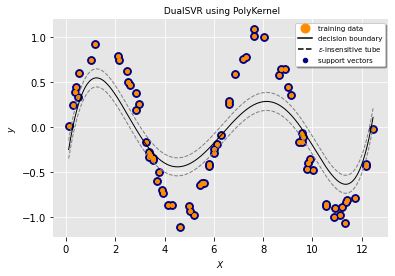

svr r2 score is 0.5517886427293541
svr found 75 support vectors from 75 examples
svr b is -0.06413651711427736


In [17]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              fit_intercept=True, lagrangian_solver='lsqr', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-3.5406e+00	pcost: -2.0304e+00	gap:  7.4378e-01	itn:  11	rnorm: 2.6296e+00
   1	   1	-2.9495e+00	pcost: -2.0304e+00	gap:  4.5262e-01	itn:  11	rnorm: 2.3732e+00
   2	   2	-2.5799e+00	pcost: -2.0304e+00	gap:  2.7060e-01	itn:  11	rnorm: 2.2799e+00
   3	   3	-2.3046e+00	pcost: -2.0304e+00	gap:  1.3503e-01	itn:  11	rnorm: 2.2607e+00
   4	   4	-2.0842e+00	pcost: -2.0304e+00	gap:  2.6464e-02	itn:  11	rnorm: 2.2842e+00
   5	   5	-1.9005e+00	pcost: -2.0304e+00	gap: -6.4023e-02	itn:  11	rnorm: 2.3341e+00

CPU times: user 106 ms, sys: 131 ms, total: 237 ms
Wall time: 60.1 ms


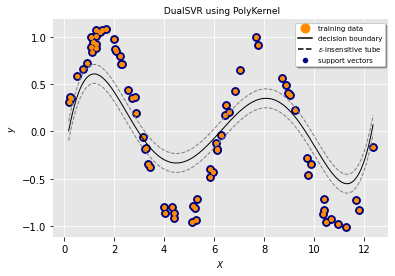

svr r2 score is 0.6645106505032261
svr found 75 support vectors from 75 examples
svr b is 0.03577968024109529


In [18]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              fit_intercept=False, lagrangian_solver='lsqr', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

In [ ]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.9380e+00
   5	-2.1595e+00
  10	-2.1678e+00
  15	-2.1770e+00
  20	-2.1815e+00
  25	-2.1845e+00
  30	-2.1848e+00
  35	-2.2273e+00
  40	-2.2347e+00
  45	-2.2382e+00
  50	-2.2427e+00
  55	-2.2449e+00

CPU times: user 1.21 s, sys: 1.23 s, total: 2.44 s
Wall time: 372 ms


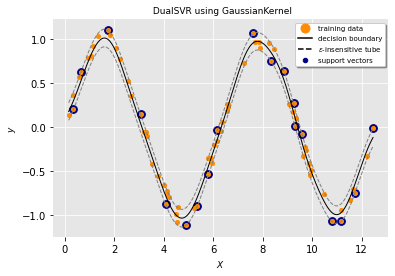

svr r2 score is 0.9818438800724006
svr found 19 support vectors from 75 examples
svr b is -0.00350379715477003

     pcost       dcost       gap    pres   dres
 0:  7.1674e+01 -1.6923e+03  2e+03  2e-15  1e-14
 1:  6.3454e+01 -8.6894e+01  2e+02  2e-14  1e-14
 2:  9.8863e+00 -1.3805e+01  2e+01  1e-14  1e-14
 3:  9.3548e-01 -5.0482e+00  6e+00  4e-15  4e-15
 4: -1.6500e+00 -2.9191e+00  1e+00  6e-15  2e-15
 5: -2.1287e+00 -2.3743e+00  2e-01  5e-15  2e-15
 6: -2.2302e+00 -2.2645e+00  3e-02  2e-15  2e-15
 7: -2.2436e+00 -2.2477e+00  4e-03  3e-15  2e-15
 8: -2.2454e+00 -2.2455e+00  7e-05  3e-16  2e-15
 9: -2.2454e+00 -2.2454e+00  7e-07  1e-15  2e-15
Optimal solution found.

CPU times: user 107 ms, sys: 104 ms, total: 211 ms
Wall time: 33.6 ms


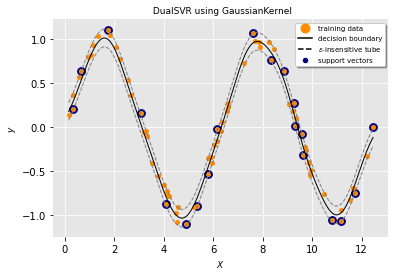

cvxopt svr r2 score is 0.9818956752270985
cvxopt svr found 20 support vectors from 75 examples
cvxopt svr b is -0.007759060829779911

CPU times: user 912 µs, sys: 431 µs, total: 1.34 ms
Wall time: 790 µs


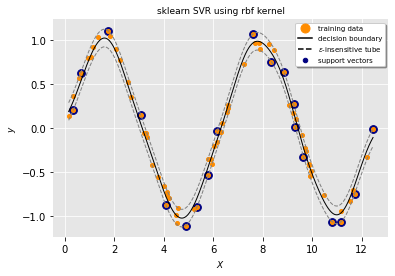

sklearn svr r2 score is 0.9820191972919681
sklearn svr found 19 support vectors from 75 examples
sklearn svr b is [0.00682271]


In [57]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer=SMORegression, verbose=5)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='rbf', gamma='auto', C=1)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [25]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-2.7192e+00	pcost: -1.3468e+00	gap:  1.0191e+00	rnorm: 1.9735e-02
  10	  10	-2.2845e+00	pcost: -1.3943e+00	gap:  6.3852e-01	rnorm: 9.4530e-03
  20	  20	-2.3071e+00	pcost: -1.3979e+00	gap:  6.5040e-01	rnorm: 8.5906e-03
  30	  30	-2.2169e+00	pcost: -1.4108e+00	gap:  5.7138e-01	rnorm: 8.7938e-03
  40	  40	-2.2143e+00	pcost: -1.4108e+00	gap:  5.6954e-01	rnorm: 8.7730e-03
  50	  50	-2.2101e+00	pcost: -1.4108e+00	gap:  5.6651e-01	rnorm: 8.7549e-03
  60	  60	-2.1569e+00	pcost: -1.4108e+00	gap:  5.2886e-01	rnorm: 7.8354e-03
  70	  70	-2.0807e+00	pcost: -1.4108e+00	gap:  4.7482e-01	rnorm: 7.5678e-03
  80	  80	-2.0044e+00	pcost: -1.4108e+00	gap:  4.2072e-01	rnorm: 7.8965e-03
  90	  90	-1.9106e+00	pcost: -1.4108e+00	gap:  3.5428e-01	rnorm: 6.7051e-03
 100	 100	-1.8629e+00	pcost: -1.4108e+00	gap:  3.2041e-01	rnorm: 7.1079e-03
 110	 110	-1.8419e+00	pcost: -1.4108e+00	gap:  3.0556e-01	rnorm: 7.0191e-03
 120	 120	-1.8328e+00	pcost: -1.4108e+00	gap:  2.9909e-01	rnorm: 6.951

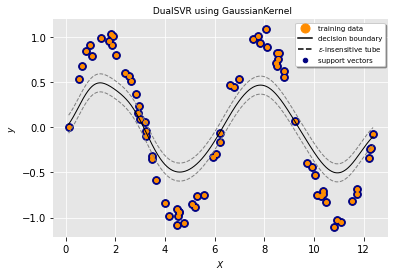

svr r2 score is 0.6103971158955385
svr found 75 support vectors from 75 examples
svr b is -0.0049374442127616425


In [28]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, 
              optimizer=AdaGrad, fit_intercept=True, verbose=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-2.3759e+00	pcost: -1.4212e+00	gap:  6.7173e-01	rnorm: 1.4863e-01
  10	  10	-1.4951e+00	pcost: -1.4212e+00	gap:  5.2018e-02	rnorm: 2.1578e-01
  20	  20	-1.4647e+00	pcost: -1.4212e+00	gap:  3.0574e-02	rnorm: 2.2091e-01
  30	  30	-1.3938e+00	pcost: -1.4212e+00	gap: -1.9305e-02	rnorm: 1.9642e-01

CPU times: user 450 ms, sys: 535 ms, total: 985 ms
Wall time: 212 ms


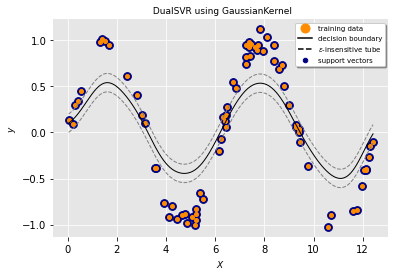

svr r2 score is 0.7226964793726702
svr found 75 support vectors from 75 examples
svr b is 0.03916819351724214


In [29]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, 
              optimizer=AdaGrad, fit_intercept=False, verbose=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')